In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
!pip install sqlalchemy_utils
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy_utils.functions import sort_query


In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# check-out the data

inspector = inspect(engine)
inspector.get_table_names()


columns1 = inspector.get_columns('Station')
for column in columns1:
    print(column["name"], column["type"])

print("------")
columns2 = inspector.get_columns('Measurement')
for column in columns2:
    print(column["name"], column["type"])    
    

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [7]:
# reflect an existing database into a new model
# reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)



In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
station=Base.classes.station
measurements=Base.classes.measurement

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

lastyear= sort_query(session.query(measurements.date), 'date')
#lastyear.all()

lastDate=max(lastyear.all()) 
# last date is [2017-08-23]

#try to calculate the last date(TRY LATER!!)
#oneyearfromlastdate=dt.date(lastDate[0:3],lastDate[5:6],lastDate[8:9])-dt.timedelta(days=365)
#print(oneyearfromlastdate)


# Perform a query to retrieve the data and precipitation scores

lastyeardata= session.query(measurements.date, measurements.prcp).\
    filter(measurements.date >'2016-08-23').all()
#print(lastyeardata)
#print(len(lastyeardata))---gives 2000+records, out of original 19,000+ records

# Save the query results as a Pandas DataFrame and set the index to the date column

lastyearplot=pd.DataFrame(lastyeardata)    
lastyearplot


# Sort the dataframe by date
lastyearplotsorted=lastyearplot.sort_values('date')
lastyearplotsorted=lastyearplotsorted.set_index('date')
#lastyearplotsorted

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500.]),
 <a list of 7 Text major ticklabel objects>)

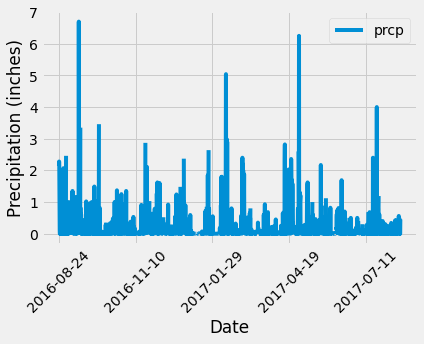

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data

lastyearplotsorted.plot()
plt.ylabel("Precipitation (inches)")
plt.xlabel("Date")
plt.xticks(rotation=45)


In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
lastyearplotsorted.describe()



,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?

uniquestation= session.query(station.station).all()
#uniquestation
print(len(uniquestation))

9


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

stationcounts=session.query(measurements.station,func.count(measurements.station)).group_by(measurements.station).order_by(func.count(measurements.station).desc()).all()
stationcounts


#need a list of stations by "session query", then a function of counts for each station (done by groupby);  then orderby on the counts (ie the func count); then the desc() in the orderby so that we have a descending order).  

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
#do a count of stations a different way

#stationcounts2=sort_query(session.query(func.count(measurements.station)).group_by(measurements.station).all()
#stationcounts2


In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

session.query(func.min(measurements.tobs),func.max(measurements.tobs),func.avg(measurements.tobs)).filter(measurements.station=="USC00519281").all()



[(54.0, 85.0, 71.66378066378067)]

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

lastyeardatatemp= session.query(measurements.date, measurements.tobs).\
    filter((measurements.date >'2016-08-23')& (measurements.station=="USC00519281")).all()
#print(lastyeardatatemp)
#print(len(lastyeardatatemp))
#gives 2000+records, out of original 19,000+ records for the date filter;  then additional filter for the station gives 351 records)

# Save the query results as a Pandas DataFrame and set the index to the date column

lastyearplot2=pd.DataFrame(lastyeardatatemp)    
lastyearplot2


,date,tobs
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0
...,...,...
346,2017-08-14,77.0
347,2017-08-15,77.0
348,2017-08-16,76.0
349,2017-08-17,76.0


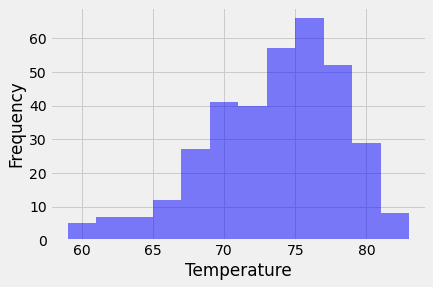

In [19]:
# make a histogram (number of bins=12 per README, to see which looks representative)
x=lastyearplot2["tobs"]
plt.hist(x,12, facecolor='blue', alpha=0.5)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

## Bonus Challenge Assignment

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates


def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
#     output=(
#         f"measurements={session.query(measurements.tobs, measurements.station).all()}\n" 
#         f"func.min={session.query(func.min(measurements.tobs)).all()}\n"
#         f"func.avg={session.query(func.avg(measurements.tobs)).all()}\n"
#         f"func.max={session.query(func.max(measurements.tobs)).all()}\n"
#     )
#     print(output)
    return session.query(func.min(measurements.tobs), func.avg(measurements.tobs), func.max(measurements.tobs)).\
        filter(measurements.date >= start_date).filter(measurements.date <= end_date).all()



In [21]:
start_date="2016-10-28"
end_date="2017-08-18"


# function usage example
(calc_temps(start_date, end_date))

[(58.0, 73.82077051926298, 87.0)]

In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

def calc_temps(start_date, end_date, vacation_station):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """

    return session.query(func.min(measurements.tobs), func.avg(measurements.tobs), func.max(measurements.tobs)).\
        filter(measurements.date >= start_date).filter(measurements.date <= end_date).filter(measurements.station==vacation_station).all()


In [23]:
start_date="2016-10-28"
end_date="2017-08-18"
vacation_station="USC00519281"

# function usage example
(calc_temps(start_date, end_date, vacation_station))

[(59.0, 72.15734265734265, 83.0)]

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)



In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

def calc_prcp(start_date, end_date, vacation_station):
 

    return session.query(func.sum(measurements.prcp)).\
        filter(measurements.date >= start_date).filter(measurements.date <= end_date).filter(measurements.station==vacation_station).all()


In [26]:
start_date="2016-10-28"
end_date="2016-11-08"
vacation_station="USC00519281"

# function usage example
(calc_prcp(start_date, end_date, vacation_station))

[(0.7300000000000001)]

In [27]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurements.tobs), func.avg(measurements.tobs), func.max(measurements.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurements.date) == date).all()
    


In [28]:
vacation_date="10-28"
daily_normals(vacation_date)


[(68.0, 74.75471698113208, 82.0)]

In [29]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

def daily_normalsvacation(date, vacation_station):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurements.tobs), func.avg(measurements.tobs), func.max(measurements.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurements.date) == date).filter(measurements.station==vacation_station).all()


In [30]:
#define the station first, before running the def function
vacation_station="USC00519281"

vacmin, vacavg, vacmax = list(daily_normalsvacation(vacation_date,vacation_station)[0])
#daily_normalsvacation("10-28",vacation_station)
#type(list(daily_normalsvacation("10-28",vacation_station)[0])[2])

In [31]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
vacationdata=pd.DataFrame({
    "Min Temp": [vacmin],
    "Average Temp": [vacavg],
    "Max Temp": [vacmax]
},index=[vacation_date]).rename(index="Vacation_Date")
vacationdata

TypeError: Index(...) must be called with a collection of some kind, 'Vacation_Date' was passed

In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
